In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Combien coûte l'intelligence ?

Cette interface vous permettra de tester differents algorithmes de classifications et de faire varier les paramètres des images données en entrée.
Les images sont tirées de la base de données MNIST.

## Choix des paramètres


In [2]:
from ipywidgets import widgets , interact
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

param = {'nbits': '8bit', 'res':'28x28', 'p':0}
def f(sender):
    print(nbits.value, resolution.value, erreur.value)
    param['nbits'] = nbits.value[0]+'bit'
    param['res'] = resolution.value
    param['p'] = erreur.value

nbits=widgets.RadioButtons(
    options=["8 bits", "4 bits", "1 bit"],
    description="Nombre de bits par pixel")
display(nbits)

resolution=widgets.RadioButtons(
    options=["28x28", "14x14"],
    description="Resolution des images")
display(resolution)

erreur = widgets.FloatSlider(value=0.1, min=0, max=1.0, step=0.1, description="P(erreur/bit)")
display(erreur)

valider = widgets.Button(description="VALIDER")
display(valider)

valider.on_click(f)

4 bits 28x28 0.4


## Voici un exemple du type d'images fournies à l'algorithme

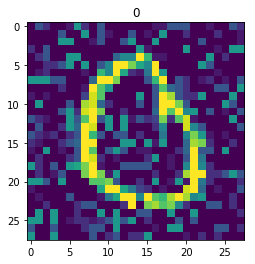

In [3]:
train_images = []
test_images = []
train_labels=np.load("./data/train_labels.npy")
test_labels=np.load("./data/test_labels.npy")
random_image = []

res = int(param['res'].split("x")[0])
p = param['p']
nb= int(param['nbits'][0])
def pixel_bit_error(pe, image, nbits):
    N = len(image)
    err_image = np.zeros_like(image)
    pixel_error = np.random.choice([0, 1], N, p=[1-pe, pe])
    for i in range(N):
        if pixel_error[i]:
            bit = np.random.randint(0, nbits)
            nrm = 2**nbits - 1.0
            err_image[i] = (int(image[i]*nrm) ^ (2**bit))/nrm
        else:
            err_image[i] = image[i]
    return err_image

def load_data(sender):
    global train_images
    global test_images
    nbit, res, p = param.values()
    path = "./data/"+ nbit +"/"+nbit+"_"+ res +"_train_images.npy"
    train_images = np.load(path)
    path = "./data/"+ nbit +"/"+nbit+"_"+ res +"_test_images.npy"
    test_images = np.load(path)
    k = np.random.randint(1000)
    image = pixel_bit_error(p, train_images[k], int(nbit[0]))
    plt.title(str(np.argmax(train_labels[k])))
    plt.imshow(image.reshape((int(res.split("x")[0]), int(res.split("x")[0]))))
    plt.show()
    random_image = image

load = widgets.Button(description="CHARGER LES IMAGES")
display(load)

load.on_click(load_data)


## Paramètres du classifieur

In [4]:
gen = 0
b_size = 0

def f2(sender):
    global gen
    global b_size
    gen = generations.value
    b_size = batchSize.value
    print(gen, b_size)
generations=widgets.IntSlider(value=20, min=0, max=500, step=10, description="Nombre de generations")
display(generations)

batchSize=widgets.IntSlider(value=40, min=0, max=500, step=10, description="Taille des échantillons")
display(batchSize)

valider2 = widgets.Button(description="VALIDER")
display(valider2)

valider2.on_click(f2)

20 40


## Réseau de neurones

<IPython.core.display.Javascript object>


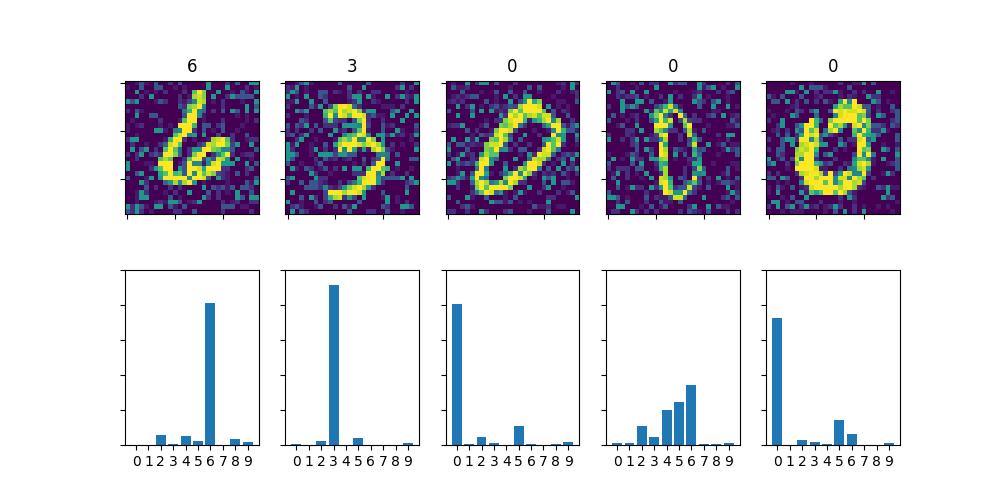

LEARNING FINISHED


In [5]:
%matplotlib notebook
from Caliente import Caliente

t_size = 5000
NN = Caliente([res*res, 30, 10], 0)



training = [(x.transpose(), y.transpose()) for x,y in zip(train_images, train_labels)]



randomsample = np.random.choice(len(test_images),5)
test_sample = [np.array(pixel_bit_error(p, test_images[i], nb)) for i in randomsample]
test_sample_labels = [test_labels[k] for k in randomsample]


fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,5))
for i in range(len(test_sample)):
    image = test_sample[i].reshape((res,res))
    men_means = NN.passthrough(test_sample[i])
    ind = np.arange(10) 
    ax[0, i].set_yticklabels([])
    ax[0, i].set_xticklabels([])
    ax[0, i].set_title(str(np.argmax(test_sample_labels[i])))
    ax[0, i].imshow(image)
    ax[1, i].set_ylim(0,1)
    ax[1, i].set_yticklabels([])
    ax[1, i].set_xticks(ind)
    ax[1, i].set_xticklabels([0, 1,2,3,4,5,6,7,8,9])
    ax[1, i].bar(ind,men_means[:,0]/sum(men_means), 0.8)
fig.canvas.draw()
plt.show()
def update(ax):
    for i in range(len(test_sample)):
        men_means = NN.passthrough(test_sample[i])
        ind = np.arange(10)
        ax[1, i].clear()
        ax[1, i].set_ylim(0,1)
        ax[1, i].set_yticklabels([])
        ax[1, i].set_xticks(ind)
        ax[1, i].set_xticklabels([0, 1,2,3,4,5,6,7,8,9])
        ax[1, i].bar(ind,men_means[:,0]/sum(men_means), 0.8)
    fig.canvas.draw()

plt.show()
for k in range(0,gen):
    NN.gradient_descent(training[:t_size], 1, b_size, 0.6)
    update(ax)
    
print("LEARNING FINISHED")
    



## Taux de reussite

In [27]:
test_data = [(np.array(pixel_bit_error(p, x, nb)).transpose(), y.transpose()) for x,y in zip(test_images, test_labels)]
succ = NN.evaluate(test_data[:2000])

print(succ/2000)

0.6
